In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
plt.rcParams['figure.figsize'] = [16, 8]

Let's import the different tables we need to work with.

In [32]:
conv = pd.read_csv("C://Users//Juan Diego//Desktop//Rover//Datasets//conversations_conversation.csv")
conv_pet = pd.read_csv("C://Users//Juan Diego//Desktop//Rover//Datasets//conversations_conversation_pets.csv")
conv_mess = pd.read_csv("C://Users//Juan Diego//Desktop//Rover//Datasets//conversations_message.csv")
conv_rev = pd.read_csv("C://Users//Juan Diego//Desktop//Rover//Datasets//conversations_review.csv")
peop_per = pd.read_csv("C://Users//Juan Diego//Desktop//Rover//Datasets//people_person.csv")
peop_tst = pd.read_csv("C://Users//Juan Diego//Desktop//Rover//Datasets//people_testsegmentation.csv")
pets = pd.read_csv("C://Users//Juan Diego//Desktop//Rover//Datasets//pets_pet.csv")
srvc = pd.read_csv("C://Users//Juan Diego//Desktop//Rover//Datasets//services_service.csv")

## How many users have signed up for the site?

In [33]:
peop_per.date_joined.nunique()

64476

## How many users signed up prior to 2021-10-31?

In [34]:
peop_per["date_joined"] = pd.to_datetime(peop_per["date_joined"])
peop_per.dtypes
peop_per[peop_per["date_joined"]< "2021-10-31"].shape[0]

35575

## How many users offer pet-caring services?

In [35]:
srvc.provider_id.nunique()

12600

## What % of users that do not offer services have ever sent a conversation?

First, to arrive at the users that do not offer services, this would be set difference (all users - users with at least 1 service = users that do not offer services)

In [36]:
all_users = set(peop_per["id"].unique())
offer_users = set(srvc.provider_id.unique())
no_offer_users = all_users.difference(offer_users) #this is users that have never offered a service
print(len(no_offer_users))
buy_users = set(conv.requester_id.unique())
no_off_buy = no_offer_users.intersection(buy_users) #this is users that have never offered a service, but have started a conv
print(len(no_offer_users))
print(len(no_off_buy))
print(len(no_off_buy)/len(no_offer_users)) #the result

51876
51876
44163
0.8513185287994448


## What % of conversations have successfully booked?

In [37]:
print(conv.shape[0], conv.booked_at.nunique(), conv[~conv["cancelled_at"].isna()].cancelled_at.nunique())

79413 33066 3250


In [38]:
print(conv.booked_at.nunique()/ conv.shape[0]) #this is the number without considering cancellations

0.4163801896414945


## 1) In each month, what were the gross billings and net revenue across all bookings?

First, I need the records in conv for which booked_at is not null (so the conversation led to a service being booked) & cancelled_at is null (so the service was actually provided and paid for)

In [39]:
conv_bkd_not_cn = conv.loc[(~conv.booked_at.isna()) & (conv.cancelled_at.isna()), :]

Now, for these records, I have the booking total, service_id, units. For the billing/income, I need the owner's fee for each owner that actually hired a service. We need to use pd.merge() on conv_bkd_not_cn and the peop_per df to bring this data.

In [40]:
conv_bkd_not_cn_f = pd.merge(left = conv_bkd_not_cn, right = peop_per, left_on = "requester_id", right_on = "id", how = "left")
conv_bkd_not_cn_f.head()

,id_x,start_date,end_date,units,added,booking_total,cancellation_fault,requester_id,service_id,booked_at,cancelled_at,id_y,first_name,last_name,email,channel,date_joined,photo,fee,gender
0,1,2022-04-10,2022-04-16,6,2022-03-29 09:49:55.672654,252,NaN,64476,10272,2022-03-30 01:13:31.396982,NaN,64476,Carolann,Matherson,carolann.matherson493@rover.com,Google,2022-03-28 07:48:19.584522,https://placekitten.com/206/343,0.07,f
1,3,2022-04-23,2022-04-24,1,2022-04-16 11:26:48.319234,69,NaN,64474,15367,2022-04-19 21:46:57.694034,NaN,64474,Vincenzo,Laducer,vincenzo.laducer493@hotmail.com,Google,2022-04-12 00:28:27.741263,https://placekitten.com/259/291,0.07,m
2,6,2022-04-28,2022-05-01,3,2022-04-16 13:01:53.533798,216,NaN,64469,11387,2022-04-19 06:47:02.604882,NaN,64469,Kamala,Caddel,kamala.caddel138@gmail.com,Google,2022-04-13 08:53:37.677608,https://placekitten.com/385/291,0.07,f
3,9,2022-04-12,2022-04-15,3,2022-03-31 14:03:38.120848,228,NaN,64465,20265,2022-04-05 03:09:19.287573,NaN,64465,Chauncey,Maskell,chauncey.maskell370@yahoo.com,Google,2022-03-30 10:33:31.539942,https://placekitten.com/377/393,0.07,m
4,16,2022-04-22,2022-04-26,4,2022-04-14 19:08:11.931551,120,NaN,64458,8722,2022-04-16 15:36:02.301549,NaN,64458,Sau,Calin,sau.calin585@gmail.com,Google,2022-04-12 04:19:30.891301,https://placekitten.com/356/310,0.07,f


In [41]:
conv_bkd_not_cn_f["total_w_fee"] = conv_bkd_not_cn_f["booking_total"] + conv_bkd_not_cn_f["booking_total"]*conv_bkd_not_cn_f["fee"]
conv_bkd_not_cn_f["total_w_fee"].sum()

5617924.2

Now we have the total gross billing/income, but I want to see it by month!

In [42]:
date_c = ["start_date", "end_date", "added", "booked_at", "date_joined"]
for c in date_c:
    conv_bkd_not_cn_f[c] = pd.to_datetime(conv_bkd_not_cn_f[c])
print(conv_bkd_not_cn_f.dtypes)

id_x                           int64
start_date            datetime64[ns]
end_date              datetime64[ns]
units                          int64
added                 datetime64[ns]
booking_total                  int64
cancellation_fault            object
requester_id                   int64
service_id                     int64
booked_at             datetime64[ns]
cancelled_at                  object
id_y                           int64
first_name                    object
last_name                     object
email                         object
channel                       object
date_joined           datetime64[ns]
photo                         object
fee                          float64
gender                        object
total_w_fee                  float64
dtype: object


In [43]:
conv_bkd_not_cn_f["month_booked"] = conv_bkd_not_cn_f["booked_at"].dt.month_name()
conv_bkd_not_cn_f["month_booked"] = pd.Categorical(conv_bkd_not_cn_f["month_booked"], ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])

We also want to take a look at the net revenue, which is = total_w_fee - (booking total - booking total(service fee)). We need the service fee id from the srvc df in order to make this calculation. pd.merge() joining on "service_id" and "id"

In [44]:
conv_bkd_nc_complete = pd.merge(left = conv_bkd_not_cn_f, right = srvc, left_on = "service_id", right_on = "id", how = "left")
conv_bkd_nc_complete.head()

,id_x,start_date,end_date,units,added_x,booking_total,cancellation_fault,requester_id,service_id,booked_at,...,special_needs_experience,takes_small_dogs,takes_medium_dogs,takes_large_dogs,takes_puppies,max_dogs,provider_id,fee_y,price,added_y
0,1,2022-04-10,2022-04-16,6,2022-03-29 09:49:55.672654,252,NaN,64476,10272,2022-03-30 01:13:31.396982,...,0,1,1,0,1,4,6007,0.2,21,2021-06-22 13:04:09.769296
1,3,2022-04-23,2022-04-24,1,2022-04-16 11:26:48.319234,69,NaN,64474,15367,2022-04-19 21:46:57.694034,...,0,1,1,1,0,7,8983,0.2,23,2021-12-23 05:25:34.579834
2,6,2022-04-28,2022-05-01,3,2022-04-16 13:01:53.533798,216,NaN,64469,11387,2022-04-19 06:47:02.604882,...,0,1,0,1,1,4,6661,0.2,36,2022-01-12 04:33:34.874966
3,9,2022-04-12,2022-04-15,3,2022-03-31 14:03:38.120848,228,NaN,64465,20265,2022-04-05 03:09:19.287573,...,0,1,1,1,1,3,11865,0.2,38,2022-03-11 05:55:27.205574
4,16,2022-04-22,2022-04-26,4,2022-04-14 19:08:11.931551,120,NaN,64458,8722,2022-04-16 15:36:02.301549,...,1,0,1,0,1,5,5118,0.2,30,2021-07-05 00:22:12.701395


Now let's create the 2 new columns we need: one to know what did we pay service providers, and another one with the net revenue per booking.

In [45]:
conv_bkd_nc_complete["prov_pay"] = conv_bkd_nc_complete["booking_total"] - conv_bkd_nc_complete["booking_total"]*conv_bkd_nc_complete["fee_y"]
conv_bkd_nc_complete["net_revenue"] = conv_bkd_nc_complete["total_w_fee"] - conv_bkd_nc_complete["prov_pay"]

In [46]:
conv_bkd_nc_complete["year-month"] = conv_bkd_nc_complete["booked_at"].dt.to_period("M")
conv_bkd_nc_complete["year-month"] = conv_bkd_nc_complete["year-month"].astype("str")

# Answer to question 1:

In [47]:
X2 = conv_bkd_nc_complete.groupby(by="year-month", as_index=False).agg({ "total_w_fee" : "sum", "net_revenue" : "sum"})
print(X2.head(30))

   year-month  total_w_fee  net_revenue
0     2020-05      2727.48       454.58
1     2020-06     13134.54      2189.09
2     2020-07     27990.84      4665.14
3     2020-08     44457.72      7409.62
4     2020-09     49687.56      8400.51
5     2020-10     69135.33     12857.68
6     2020-11     86374.17     16138.67
7     2020-12    118944.21     22329.81
8     2021-01    136658.34     25718.89
9     2021-02    133240.47     25108.72
10    2021-03    168063.66     33012.71
11    2021-04    196862.16     39578.91
12    2021-05    231620.61     48150.81
13    2021-06    246159.84     52253.09
14    2021-07    268616.04     57915.14
15    2021-08    311098.59     68079.39
16    2021-09    300327.63     68645.73
17    2021-10    354100.67     81439.67
18    2021-11    364516.70     84949.90
19    2021-12    403985.96     95399.31
20    2022-01    478107.58    112944.93
21    2022-02    468192.66    111661.66
22    2022-03    557278.16    133721.26
23    2022-04    586643.28    141137.88


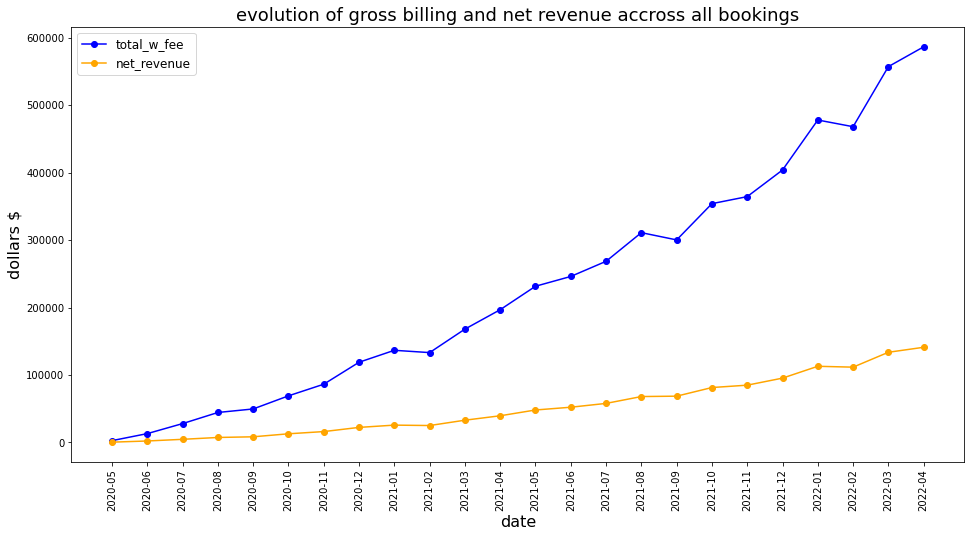

In [48]:
fix, ax = plt.subplots(sharex=True, sharey=True)

ax.plot("year-month", "total_w_fee", data=X2, color="blue", marker="o")
ax.plot("year-month", "net_revenue", data=X2, color="orange", marker="o")
ax.set_xlabel("date", fontsize=16)
ax.set_ylabel("dollars $", fontsize=16)
ax.set_title("evolution of gross billing and net revenue accross all bookings", fontsize=18)
ax.legend(fontsize="large")
for tick in ax.get_xticklabels():
        tick.set_rotation(90)
plt.show()

## 2) Define take rate to be the percentage of gross billings that is net revenue. In the previous example, the take rate is slightly more than 19% since 20/105 is approximately 0.1905. In each month, what was the aggregate take rate?

# Answer to question 2:

In [49]:
conv_bkd_nc_complete["take_rate"] = conv_bkd_nc_complete["net_revenue"] / conv_bkd_nc_complete["total_w_fee"]
q2 = conv_bkd_nc_complete.groupby(by="year-month", as_index=False).agg({ "total_w_fee" : "sum", "net_revenue" : "sum", "take_rate": "mean"})
print(q2)

   year-month  total_w_fee  net_revenue  take_rate
0     2020-05      2727.48       454.58   0.166667
1     2020-06     13134.54      2189.09   0.166667
2     2020-07     27990.84      4665.14   0.166667
3     2020-08     44457.72      7409.62   0.166667
4     2020-09     49687.56      8400.51   0.168644
5     2020-10     69135.33     12857.68   0.185727
6     2020-11     86374.17     16138.67   0.186854
7     2020-12    118944.21     22329.81   0.187398
8     2021-01    136658.34     25718.89   0.187876
9     2021-02    133240.47     25108.72   0.188443
10    2021-03    168063.66     33012.71   0.196215
11    2021-04    196862.16     39578.91   0.201952
12    2021-05    231620.61     48150.81   0.208299
13    2021-06    246159.84     52253.09   0.213077
14    2021-07    268616.04     57915.14   0.215470
15    2021-08    311098.59     68079.39   0.218204
16    2021-09    300327.63     68645.73   0.227747
17    2021-10    354100.67     81439.67   0.230699
18    2021-11    364516.70     

## 3) Did take rate trend up or trend down?

# Answer to question 3:

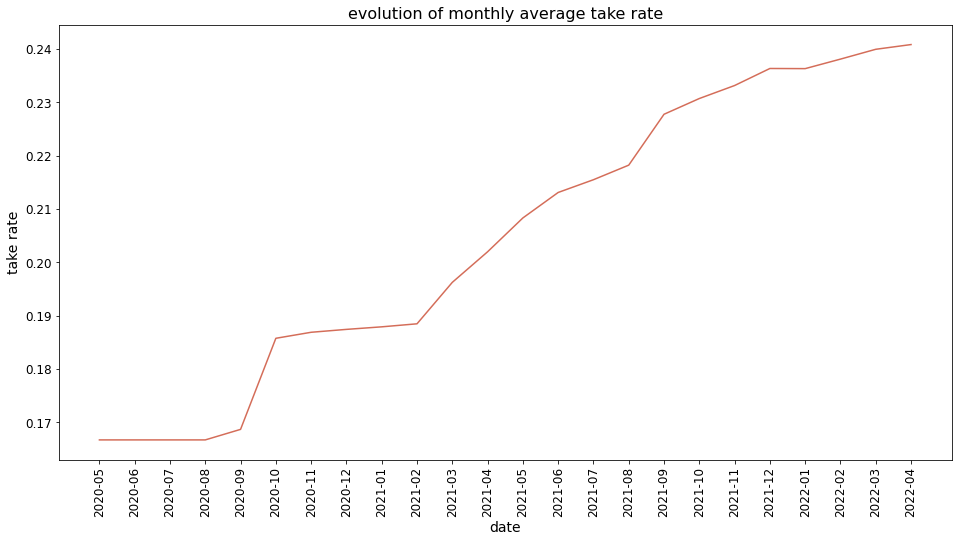

In [50]:
plt.plot("year-month", "take_rate", data=q2, color="#d46d59")
plt.xlabel("date", fontsize=14)
plt.ylabel("take rate", fontsize=14)
plt.title("evolution of monthly average take rate", fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(rotation=90, fontsize=12)
plt.show()

Take rate clearly trended up over time! it is evident in this graph. This is good news for Rover!

## 4) Provide an explanation for this trend. Be sure to provide additional data/charts/evidence that justify your explanation. Any claims should be backed by data.

So, take rate is a KPIs elaborated from "net_revenue" and "total_w_fee", it is just the expression TR:

TR = net_revenue/total_w_fee, which based on our variables means:

TR = bt + bt(fee1) - bt + bt(fee2)) 
           bt + bt(fee1)

TR = bt(fee1) + bt(fee2)
        bt + bt(fee1)

Then, from an algebraic point of view, TR can only increase (considering all other variables unchanging) if:

fee2 increases
fee1 increases (given that bt(fee2) > bt, as fee2 > 0)

Therefore, to find an explanation for this behaviour, we will look at the particular behaviour of these 2 variables, the fee we charge the pet owners and the fee we discount from the payments we make to the service providers.

We want to know, for each booking_id (conversation_id that has a booked_at date & does not have a cancelled date), how many different pet_ids were involved (So we know the number of pets per booked service).

In [51]:
pets_per_service = conv_pet.groupby(by="conversation_id", as_index=False).pet_id.count()
pets_per_service.head(10)

,conversation_id,pet_id
0,1,2
1,2,2
2,3,3
3,4,2
4,5,2
5,6,2
6,7,2
7,8,1
8,9,2
9,10,1


In [52]:
conv_bkd_nc_complete2 = pd.merge(left = conv_bkd_nc_complete, right = pets_per_service, left_on = "id_x", right_on = "conversation_id", how = "left")

In [53]:
conv_bkd_nc_complete2["year"] = conv_bkd_nc_complete2["booked_at"].dt.year.astype("int")
conv_bkd_nc_complete2["month"] = conv_bkd_nc_complete2["booked_at"].dt.month

In [56]:
conv_bkd_nc_complete2.columns

Index(['id_x', 'start_date', 'end_date', 'units', 'added_x', 'booking_total',
       'cancellation_fault', 'requester_id', 'service_id', 'booked_at',
       'cancelled_at', 'id_y', 'first_name', 'last_name', 'email', 'channel',
       'date_joined', 'photo', 'fee_x', 'gender', 'total_w_fee',
       'month_booked', 'id', 'service_type', 'cancellation_policy',
       'can_provide_oral_medication', 'can_provide_injected_medication',
       'senior_dog_experience', 'special_needs_experience', 'takes_small_dogs',
       'takes_medium_dogs', 'takes_large_dogs', 'takes_puppies', 'max_dogs',
       'provider_id', 'fee_y', 'price', 'added_y', 'prov_pay', 'net_revenue',
       'year-month', 'take_rate', 'conversation_id', 'pet_id', 'year',
       'month'],
      dtype='object')

In [57]:
conv_bkd_nc_complete2.columns = ['conversation_id', 'start_date', 'end_date', 'units_of_service',
       'added_on', 'booking_total', 'cancellation_fault', 'requester_id',
       'service_id', 'booked_at', 'cancelled_at', 'user_id', 'first_name',
       'last_name', 'email', 'channel', 'date_joined', 'photo', 'fee_owner',
       'gender', 'total_w_fee', 'month_booked', 'service_id2', 'service_type',
       'cancellation_policy', 'can_provide_oral_medication',
       'can_provide_injected_medication', 'senior_dog_experience',
       'special_needs_experience', 'takes_small_dogs', 'takes_medium_dogs',
       'takes_large_dogs', 'takes_puppies', 'max_dogs', 'provider_id',
       'fee_provider', 'price', 'added_y', 'prov_pay', 'net_revenue',
       'year-month', 'take_rate', 'conversation_id2', 'number_of_pets', 'year', 'month']

In [58]:
conv_bkd_nc_complete2

,conversation_id,start_date,end_date,units_of_service,added_on,booking_total,cancellation_fault,requester_id,service_id,booked_at,...,price,added_y,prov_pay,net_revenue,year-month,take_rate,conversation_id2,number_of_pets,year,month
0,1,2022-04-10,2022-04-16,6,2022-03-29 09:49:55.672654,252,NaN,64476,10272,2022-03-30 01:13:31.396982,...,21,2021-06-22 13:04:09.769296,201.6,68.04,2022-03,0.252336,1,2,2022,3
1,3,2022-04-23,2022-04-24,1,2022-04-16 11:26:48.319234,69,NaN,64474,15367,2022-04-19 21:46:57.694034,...,23,2021-12-23 05:25:34.579834,55.2,18.63,2022-04,0.252336,3,3,2022,4
2,6,2022-04-28,2022-05-01,3,2022-04-16 13:01:53.533798,216,NaN,64469,11387,2022-04-19 06:47:02.604882,...,36,2022-01-12 04:33:34.874966,172.8,58.32,2022-04,0.252336,6,2,2022,4
3,9,2022-04-12,2022-04-15,3,2022-03-31 14:03:38.120848,228,NaN,64465,20265,2022-04-05 03:09:19.287573,...,38,2022-03-11 05:55:27.205574,182.4,61.56,2022-04,0.252336,9,2,2022,4
4,16,2022-04-22,2022-04-26,4,2022-04-14 19:08:11.931551,120,NaN,64458,8722,2022-04-16 15:36:02.301549,...,30,2021-07-05 00:22:12.701395,96.0,32.40,2022-04,0.252336,16,1,2022,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29811,79398,2022-03-19,2022-03-21,2,2022-03-12 20:05:52.443133,128,NaN,12609,4501,2022-03-13 10:35:52.381303,...,32,2020-07-10 18:34:54.780189,108.8,28.16,2022-03,0.205607,79398,2,2022,3
29812,79402,2021-07-21,2021-07-26,5,2021-07-09 14:11:59.340664,310,NaN,12606,11294,2021-07-17 07:13:27.181453,...,31,2021-05-14 22:31:21.896942,248.0,77.50,2021-07,0.238095,79402,2,2021,7
29813,79404,2022-03-02,2022-03-05,3,2022-02-22 05:48:19.054328,132,NaN,12606,10244,2022-02-26 16:30:38.796213,...,22,2021-11-21 12:08:37.003850,105.6,33.00,2022-02,0.238095,79404,2,2022,2
29814,79407,2021-01-23,2021-01-28,5,2021-01-11 14:24:51.164467,350,NaN,12604,20187,2021-01-19 05:43:08.599332,...,35,2020-10-06 10:12:54.339605,297.5,70.00,2021-01,0.190476,79407,2,2021,1


A dataframe to plot evolution over time of different variables and aggregations

In [59]:
q4 = conv_bkd_nc_complete2.groupby(by="year-month", as_index=False).agg\
({ "conversation_id" : "count", "price" : "mean", "units_of_service" : "mean", "number_of_pets" : "mean", \
  "booking_total" : "sum", "fee_owner" : "mean", "total_w_fee" : "sum", \
  "fee_provider": "mean", "prov_pay" : "sum" , \
  "net_revenue" : "sum", "take_rate": "mean"})

A dataframe to plot the monthly average, monthly count or monthly sum of different variables

In [60]:
q4m = conv_bkd_nc_complete2.groupby(by="month", as_index=False).agg\
({ "conversation_id" : "count", "price" : "mean", "units_of_service" : "mean", "number_of_pets" : "mean", \
  "booking_total" : "sum", "fee_owner" : "mean", "total_w_fee" : "sum", \
  "fee_provider": "mean", "prov_pay" : "sum" , \
  "net_revenue" : "sum", "take_rate": "mean"})

A dataframe to plot the yearly average, yearly count or monthly count of different variables

In [61]:
q4y = conv_bkd_nc_complete2.groupby(by="year", as_index=False).agg\
({ "conversation_id" : "count", "price" : "mean", "units_of_service" : "mean", "number_of_pets" : "mean", \
  "booking_total" : "sum", "fee_owner" : "mean", "total_w_fee" : "sum", \
  "fee_provider": "mean", "prov_pay" : "sum" , \
  "net_revenue" : "sum", "take_rate": "mean"})

In [62]:
def show_evolution(y, A):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle('Analysis of ' + A, fontsize=18)

    ax1.plot("year-month", y, data=q4, color="#d46d59")
    ax1.set_xlabel("date", fontsize=14)
    ax1.set_ylabel(A, fontsize=14)
    ax1.set_title(A + " evolution", fontsize=14)
    for tick in ax1.get_xticklabels():
        tick.set_rotation(90)

    ax2.bar("month", y, data=q4m, color="#59b37d", edgecolor="black", width=0.7)
    ax2.set_xlabel("month", fontsize=14)
    ax2.set_ylabel(A, fontsize=14)
    ax2.set_title("monthly " + A, fontsize=14)

    ax3.bar("year", y, data=q4y, color="#3668ad", edgecolor="black", width=0.4)
    ax3.set_xlabel("year", fontsize=14)
    ax3.set_ylabel(A, fontsize=14)
    ax3.set_title("yearly " + A, fontsize=14)
    ax3.set_xticks([2020, 2021, 2022])

    plt.show()

Now that we have the q4, q4m, q4y dataframes and a function to plot evolution of variables and monthly/yearly aggregations, let's discover how both owner and service fee behaved! Can they account for the surge in take rate as we think?

# Data/charts/evidence to support my answer to question 4

In [63]:
How has the average fee we charge to the owners of the pets evolved recently?

Object `recently` not found.


In [ ]:
How has the average fee we charge to the owners of the pets evolved recently

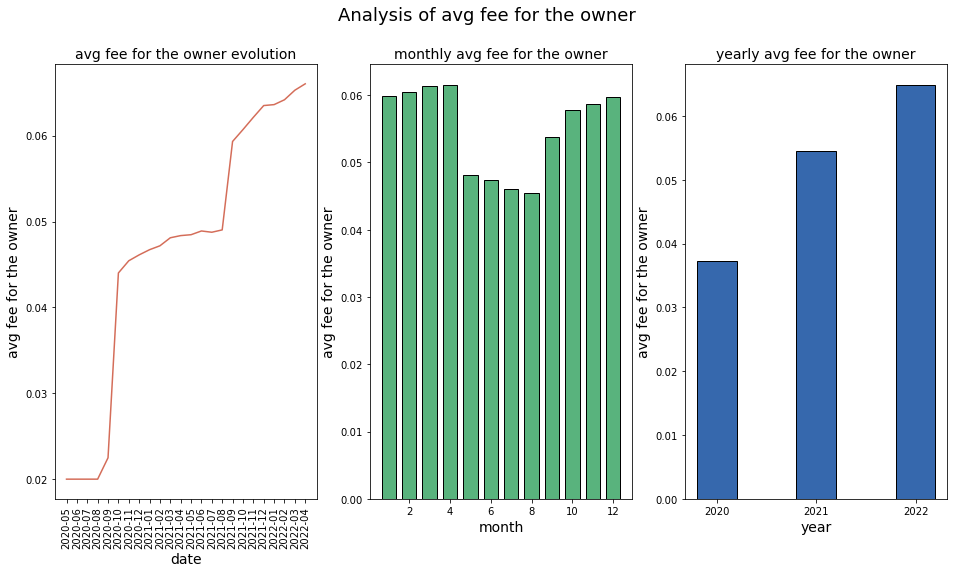

In [64]:
show_evolution(y="fee_owner", A="avg fee for the owner")

Here we make a key discovery: the surge of the average fee for the users who make the bookings. 

First of all, you can spot on the evolution graph a constant and tremendous increment of this variable. 
Secondly, focusing on the yearly average you can clearly detect it has risen over 2021 and 2022 (the average fee Rover charges user who book).

Hence, the enlargement of the fee we charge to the owner plays a great part in the uplift of the take rate, via the widening of the net revenue Rover can perceive (if you charge more to the owners and keep paying the same to service providers, then your margin grows).

Now let's analyze the service provider's fee, the net revenue and the take rate.

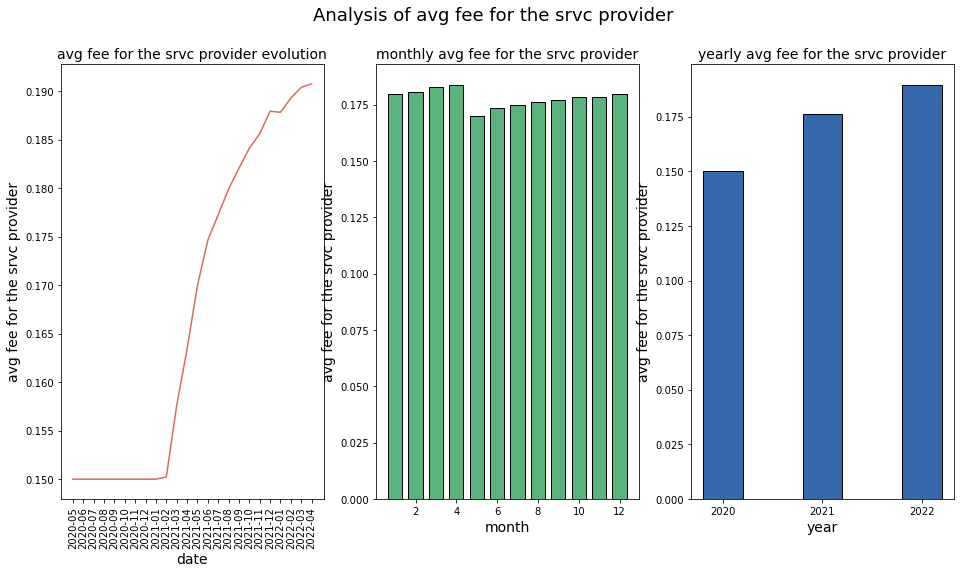

In [66]:
show_evolution(y="fee_provider", A="avg fee for the srvc provider")

Above we can observe how the avg service fee has changed: it has exploded since 2021-02. 

We can also distinguish how the yearly average has grown, from around 15% in 2020, to over 17.5% nowadays.

As the service fee determines how much we discount the booking total before paying service providers, and thus determines how much Rover keeps, a higher service fee is better for business! 

If the fee we charge the user who hires the services does not change, while the service fee increases, this grows the net revenue and the profit Rover can make.

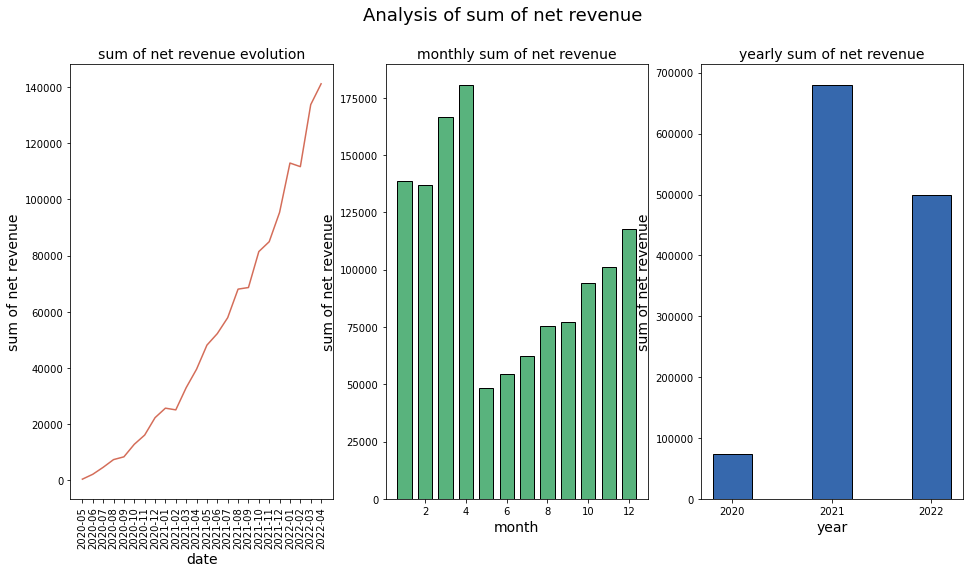

In [67]:
show_evolution(y="net_revenue", A="sum of net revenue")

We can see how the net revenue has been growing spectacularly, based on what was explained above. 2022 is set to have a great finale looking at the total in 2021 and where we already are in 2022.

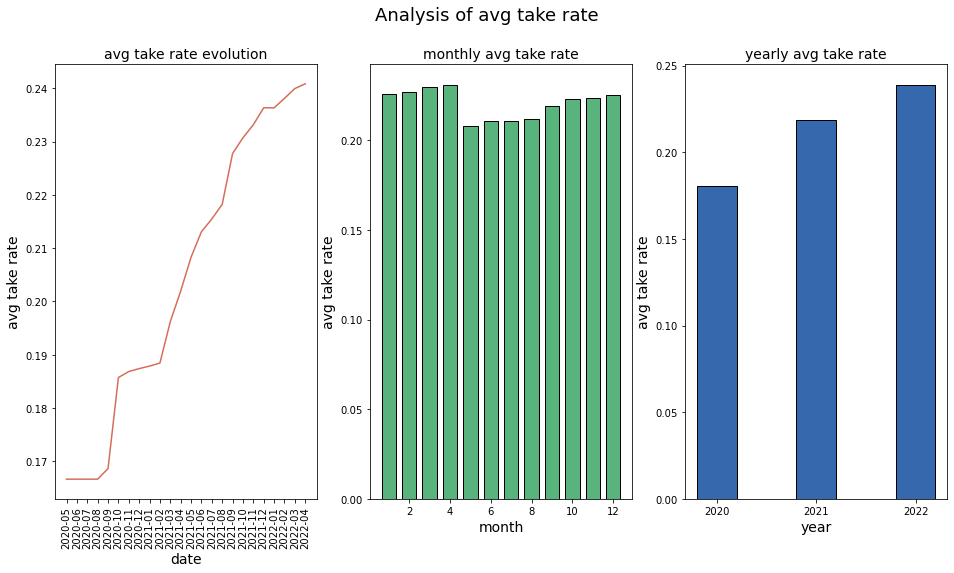

In [68]:
show_evolution(y="take_rate", A="avg take rate")

To finalize the analysis, this is the evolution of the take rate, this time considering the monthly/yearly averages. We can see that the average of 2022 is already higher than 2021!

# Answer to question 4:

Given all this evidence above, we can state the following: 

Both the increment in the average service fee and the in the average owner fee are responsible for the growth in the take rate.

As we now know that BOTH the fee we charge to the owner and the fee we use to discount from payments to service providers have grown steadily over time, these 2 variables play the MAJOR role in the take rate hike.

## 5) In a meeting, someone asks you if you think it would be a good idea to further increase the sitter service fee in order to increase net revenue. How would you reply to this suggestion?

# Reasoning and process for question 5

In pure mathematical terms, as net revenue is:

(booking_total + booking_total * owner's fee) - (booking_total - booking_total * service_fee)

This means that (holding other variables steady):

when booking_total increases, net_revenue increases (as long as service_fee > owner's fee, which is the case)

when owner's fee increases, net_revenue increases (we charge more for each booking)

when service_fee increases, net_revenue increases (we pay less to service providers)

Therefore, on the surface this seems like a good idea; any increase in service fees (while holding everything else stil) will result in higher net_revenue.

Nonetheless, in real life, variables influence each others and are co-dependent: for example, one could think that higher service fees could lead to less services being offered (service providers are receiving smaller payments, so maybe they opt out of the platform or lessen their offer), which in turn could result in less bookings, affecting then the net revenue via the diminishing of the total income (eg: before we had 1200 bookings per month, now we have 900).

In summary, the increase of the service fee for the sitter service will result in better net revenue if and only if this "reduction in payment figures to service providers" is not offset by an effect "reduction in total income because now we have less bookings (because there are less services available)".
Let's analyze the data to make sense of it.

# Are payments to service providers different when the service fee changes?

Let's isolate the sitter service fee, and analyze the payments to providers under different service fees.

In [80]:
sitter = conv_bkd_nc_complete2[conv_bkd_nc_complete2.service_type == "day-care"]

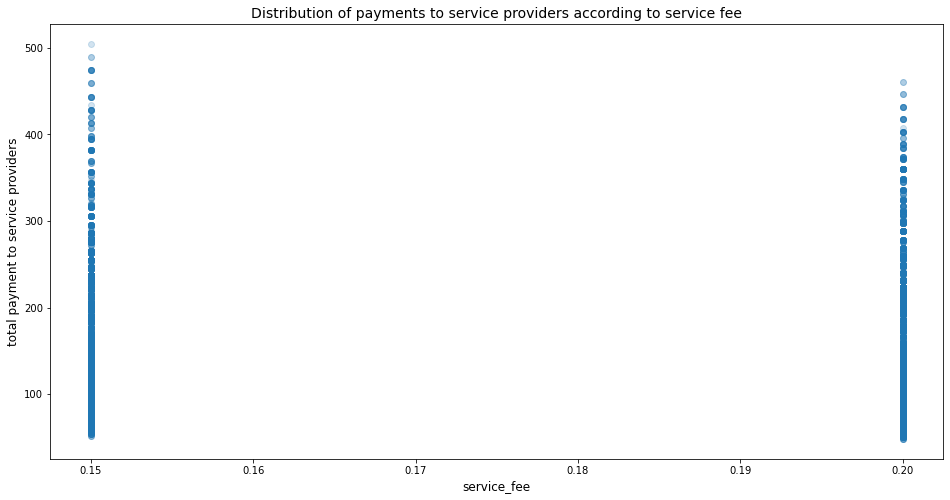

In [81]:
plt.scatter("fee_provider", "prov_pay", data=sitter, alpha=0.2)
plt.xlabel("service_fee", fontsize=12)
plt.ylabel("total payment to service providers", fontsize=12)
plt.title("Distribution of payments to service providers according to service fee", fontsize=14)
plt.show()

We can see here that we only have 2 different service_fees for the day-care service: it's either 0.15 or 0.2. Also, we can see that there are some larger payments to service providers when the fee is 0.15 compared to 0.2.

This seems in line with what we discussed: higher service_fees are better for the business and net_revenue, as we are reducing the payments to service providers.

Let's look at the mean and average payments to service providers, for bookings with service_fee 15% and bookings with service_fee 20%, to capture what we see on the scatter plot.

In [92]:
print("avg payment to sitters when fee is 20% is {}".format(round(sitter.loc[sitter.fee_provider == 0.2, :].prov_pay.mean())), "\n"
"avg payment to sitters when fee is 15% is {}".format(round(sitter.loc[sitter.fee_provider == 0.15, :].prov_pay.mean())), "\n\n"
"median payment to sitters when fee is 20% is {}".format(sitter.loc[sitter.fee_provider == 0.2, :].prov_pay.median()), "\n"
"median payment to sitters when fee is 15% is {}".format(sitter.loc[sitter.fee_provider == 0.15, :].prov_pay.median()))

avg payment to sitters when fee is 20% is 139 
avg payment to sitters when fee is 15% is 150 

median payment to sitters when fee is 20% is 116.0 
median payment to sitters when fee is 15% is 127.5


So both by taking a look at the mean and median payments to providers (booking total - booking total * service fee), we can observe that when the fee is higher (20% vs 15%), on average we pay less to service providers. This just confirms what we discussed before. 

Now, the question is, do we have much fewer services offered when the fee we keep is 20% compared to 15%?

# Looking on the supply side: do we see a sharp decline in number of offered services (because of lower payments) when service fee is 20% instead of 15%? For the sitter service specifically

In [97]:
srvc["added"] = pd.to_datetime(srvc["added"])
srvc["year-month"] = srvc["added"].dt.to_period("M")
srvc["year-month"] = srvc["year-month"].astype("str")

In [98]:
srvc_ev = srvc.loc[srvc.service_type == "day-care", :].groupby(["fee", "year-month"], as_index=False).id.count()

In [99]:
s15 = srvc_ev[srvc_ev.fee == 0.15]
s20 = srvc_ev[srvc_ev.fee == 0.2]

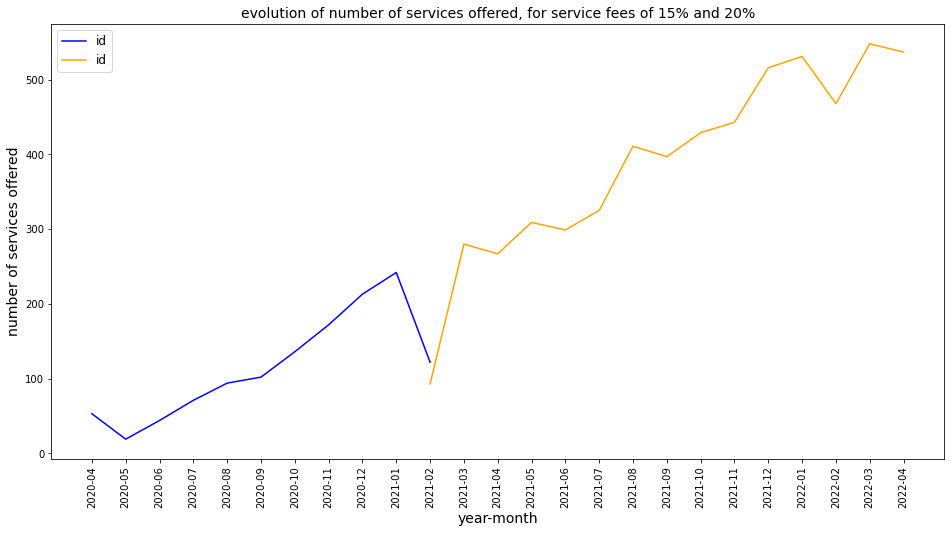

In [100]:
fix, ax = plt.subplots(sharex=True, sharey=True)

ax.plot("year-month", "id", data=s15, color="blue")
ax.plot("year-month", "id", data=s20, color="orange")
ax.set_xlabel("year-month", fontsize=14)
ax.set_ylabel("number of services offered", fontsize=14)
ax.set_title("evolution of number of services offered, for service fees of 15% and 20%", fontsize=14)
for tick in ax.get_xticklabels():
        tick.set_rotation(90)
ax.legend(fontsize="large")
plt.show()

First thing noteworthy here is that services fees of 15% and 20% for the sitter service do not co-exist: on february 2021 there was a change in strategy and from then onwards the service fee we keep from service providers payment has been 20%, before that moment it had always been 15%.
This is very clear evidence that the decrease in supply and services offered does not happen: When the change was made and service fee was 20%, the number of offered services kept on growing, relentlessly. 

Therefore, we can conclude that the increase from 15% to 20% on the service fee for the sitters was a successful move, and that it improved the net revenue (because the margin is widening and we know the supply is not dropping).

But just for some extra information, let's analyze the booking side of things to confirm our thoughts

# Looking on the demand side: do we see a sharp decline in number of bookings (cause of available supply) when service fee is 20% instead of 15%?

In [73]:
print("number of bookings when fee is 20% is {}".format(sitter.loc[sitter.fee_provider == 0.2, :].conversation_id.count()), "\n"
"number of bookings when fee is 15% is {}".format(sitter.loc[sitter.fee_provider == 0.15, :].conversation_id.count()))

number of bookings when fee is 20% is 4783 
number of bookings when fee is 15% is 3621


The number of bookings for day-care service when the service fee is 20% is actually higher than the number of booking for day-care service when the service is 15%. 
We know that the supply did not drop, but this difference has more to do with the growing of the company as a whole(there has been more activity since Rover changed the sitter's service fee on february 2021, and therefore more bookings).

In [103]:
sitter.loc[sitter.fee_provider == 0.15, :].net_revenue.mean()

35.581231703949214

In [105]:
sitter.loc[sitter.fee_provider == 0.2, :].net_revenue.mean()

45.39265941877454

As a final piece of evidence, the average net revenue by booking is :

45$ when the service fee is 20%

35$ when the service fee is 36

# Answer to question 5

In summary:

This effect clearly (reduction in services offered and so reduction in number of bookings) does not offset the effect caused by higher service fees (reduction in payments and higher margin).
Finally, we can conclude that in the case of 15% vs 20% service fees, an increase in service fees actually increases net revenue!

Regarding the suggestion to increase the sitter service fee, this could work and could increase net_revenue, as long as the increase in service fee does not drive out enough supply that the number of services offered fall drastically and so the number of bookings also take a hit.

In other words, increasing the service fee will grow net revenue as long as *the amount saved with the reduction of payments* > *the reduction in income caused by the reduction of number of total bookings due to lack of supply*

This would be my answer specifically:

"Seems like a good idea, so let's try it, but closely monitoring how the number of services offered changes when the service fee increases for service providers, because this could (possibly) cause a big reduction in bookings and then income. If we see this huge drop and the number of bookings plummeting, we should revert back the change. If we do not see a big enough reaction, then we can keep the higher service fees which will result in higher net revenue!"

## 6) For each day, determine the count of users that joined and were acquired through Google. Plot this and confirm there is an inflection point on or near 2022-01-29 .

In [106]:
peop_per.dtypes

id                      int64
first_name             object
last_name              object
email                  object
channel                object
date_joined    datetime64[ns]
photo                  object
fee                   float64
gender                 object
dtype: object

In [107]:
peop_per["date_joined2"] = peop_per.date_joined.dt.date
peop_per["date_joined2"] = pd.to_datetime(peop_per["date_joined2"])

In [108]:
goog = peop_per[peop_per.channel == "Google"]

In [109]:
goog.shape

(14341, 10)

In [110]:
goog_per_day = goog.groupby(by="date_joined2", as_index=False).id.count()

In [111]:
goog_per_day.columns

Index(['date_joined2', 'id'], dtype='object')

In [112]:
goog_per_day1 = goog_per_day.loc[goog_per_day.date_joined2 < "2022-01-29", :]
goog_per_day2 = goog_per_day.loc[goog_per_day.date_joined2 >= "2022-01-29", :]

# Answer to question 6

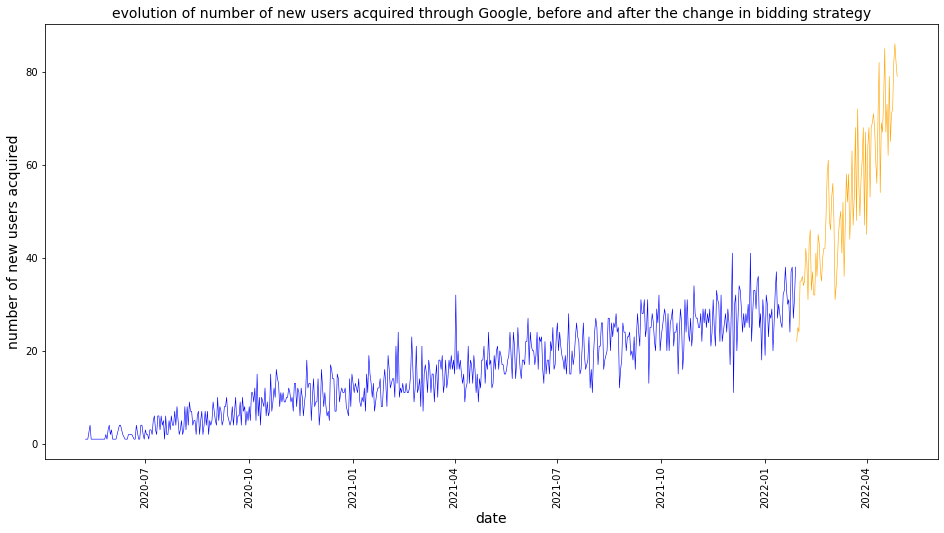

In [117]:
fix, ax = plt.subplots(sharex=True, sharey=True)

ax.plot("date_joined2", "id", data=goog_per_day1, color="blue", linewidth=0.6)
ax.plot("date_joined2", "id", data=goog_per_day2, color="orange", linewidth=0.6)
for tick in ax.get_xticklabels():
        tick.set_rotation(90)
ax.set_xlabel("date", fontsize=14)
ax.set_ylabel("number of new users acquired", fontsize=14)
ax.set_title("evolution of number of new users acquired through Google, before and after the change in bidding strategy", fontsize=14)
for tick in ax.get_xticklabels():
        tick.set_rotation(90)
plt.show()

It is clear in this graph that when Rover started to bid for 1st place new users signup grew tremendously. We can even look at the daily average for these 2 periods to have it just in 2 figure

In [118]:
goog_per_day1.id.mean()

15.504038772213248

In [119]:
goog_per_day2.id.mean()

52.71111111111111

Before the change in strategy, Rover averaged 15 new users a day. After they started to bin for 1st place, the average is 52 new users each day, an increase of 246%!

## 7) How many users were acquired via Google advertising since 2022-01-29 and what was the average cost per account?

# Answer to question 7

In [129]:
new_users_n = goog_per_day2.id.sum()
print(new_users_n, "new users were acquired through Google advertising from 29/01/2022 onwards.")

4744 new users were acquired through Google advertising from 29/01/2022 onwards.


In [130]:
avg_cost_n_acc = 213480/4744

In [133]:
print(round(avg_cost_n_acc), "was the average cost per new account acquired in that period.")

45 was the average cost per new account acquired in that period.


## 8) Estimate how many users would have been acquired had the company not changed its bidding strategy. What would have been the marketing spend in that case?

Ok, so the first question is what is the daily average number of new users that signed up under the old Google strategy. We can get that number like this:

In [138]:
daily_avg_1 = goog_per_day1.id.mean()
print("the daily average number of new users acquired using the old strategy was {}".format(round(daily_avg_1, 2)))

the daily average number of new users acquired using the old strategy was 15.5


We know that, on average we got 15.5040 new users every day under the old strategy. We also know that each new account we obtained costed Rover around 30$. The last thing to know is how many days we are looking at, that is to say, how many days have passed by under the new bidding method (from 2021-01-29 onwards), so that we can crunch some numbers about the total new users in the period and total cost.

In [143]:
days2 = goog_per_day2.date_joined2.nunique()

We have 90 days, so for 90 days Rover has been using the new bidding method on Google.
Therefore we have that for 90 days, we would have gotten 15.5040 new users every day, at an average cost of 30. We can make some estimations with this information:

# Answer to question 8

In [152]:
n_users_est = days2*daily_avg_1
print("had the company not changed it's bidding strategy, it would have gotten {} new users from 29/01/2022 onwards.".format(round(n_users_est)))

had the company not changed it's bidding strategy, it would have gotten 1395 new users from 29/01/2022 onwards.


Had Rover not changed it's bidding strategy, they would have gotten 1395 new users (assuming customer signup maintained the same behaviour) in the time period from 01-29-2022 to 29-04-2022, which is 90 days. What about the marketing expense in that case?

In [153]:
total_cost_1 = n_users_est*30
print("had the company not changed it's bidding strategy, it would have spent {}$ from 29/01/2022 onwards.".format(round(total_cost_1)))

had the company not changed it's bidding strategy, it would have spent 41861$ from 29/01/2022 onwards.


The marketing spend would have been (around) 41861$ had we not changed the bidding strategy on 29-01-2022!

## 9) How many additional accounts were created? What was the marginal cost per account for these additional accounts?

If we want to know how many additional accounts were created, we need to know how many total new users we have in both scenarios (would have with old strategy vs have with new strategy), and then subtract one from the other. For the marginal cost per account, this would be the difference in total cost (old strategy vs new strategy) divided by the difference in users acquired (old vs new strategy). Let's get started

# Answer to question 9

In [155]:
print("Had we kept the old bidding strategy we would have gotten around {} new users from 29-01-2022 onwards.".format(round(n_users_est)) , "\n\n"
"With the new bidding strategy we got {} new users from 29-01-2022 onwards.".format(new_users_n), "\n\n" "This means that {} additional accounts were created because of the change in bidding strategy!".format(new_users_n - round(n_users_est))     )

Had we kept the old bidding strategy we would have gotten around 1395 new users from 29-01-2022 onwards. 

With the new bidding strategy we got 4744 new users from 29-01-2022 onwards. 

This means that 3349 additional accounts were created because of the change in bidding strategy!


Marginal cost per account for these additional accounts?

We got 3349 additional accounts. What would have been the cost of keeping strategy 1? What is the cost we incurred with strategy 2?

In [156]:
total_cost_2 = 213480

In [157]:
print("Had we kept the old strategy from 29-01-2022 onwards the total cost would have been around {}$.".format(round(total_cost_1)) , "\n\n"
"With the new bidding strategy from 29-01-2022 onwards the total cost was {}$.".format(total_cost_2), "\n\n" 
"This means that the additional total cost for the new strategy was {}$!".format(total_cost_2 - round(total_cost_1)))

Had we kept the old strategy from 29-01-2022 onwards the total cost would have been around 41861$. 

With the new bidding strategy from 29-01-2022 onwards the total cost was 213480$. 

This means that the additional total cost for the new strategy was 171619$!


Finally, we got 3349 additional accounts because of the new strategy, and the additional cost was 171619$. So what is the marginal cost per new account?

In [158]:
marginal_cost = 171619/3349
print(marginal_cost)

51.24484920871902


The marginal cost per account for these additional accounts is 51$!

## 10) Do you think the intervention was worth it? What other sort of information would you want to know to help you make this decision?

So here we can ask some questions: 

How is the daily average of total income, provider pay and net revenue different for period 1 and 2?

In [159]:
conv_bkd_nc_complete2["booked_date"] = conv_bkd_nc_complete2["booked_at"].dt.date

In [160]:
conv_bkd_nc_complete2["booked_date"] = pd.to_datetime(conv_bkd_nc_complete2["booked_date"])
print(conv_bkd_nc_complete2["booked_date"].dtype)

datetime64[ns]


In [163]:
st1 = conv_bkd_nc_complete2.loc[conv_bkd_nc_complete2["booked_date"] < "2022-01-29", :]
st2 = conv_bkd_nc_complete2.loc[conv_bkd_nc_complete2["booked_date"] >= "2022-01-29", :]

In [164]:
days_st1 = st1.booked_date.nunique()
days_st2 = st2.booked_date.nunique()
print("before 29/01/2022, we had {} days".format(days_st1), "\n"
"from 29/01/2022 onwards, we had {} days".format(days_st2))

before 29/01/2022, we had 613 days 
from 29/01/2022 onwards, we had 91 days


# Answer to question 10

In [168]:
print("for the period with the first strategy: daily avg total_income", round(st1.total_w_fee.sum()/613), "\n"
"for the period with the first strategy: daily avg provider payments", round(st1.prov_pay.sum()/613), "\n"
"for the period with the first strategy: daily avg net revenue", round(st1.net_revenue.sum()/613), "\n\n"
      
"for the period with the second strategy: daily avg total_income", round(st2.total_w_fee.sum()/91), "\n"
"for the period with the second strategy: daily avg provider payments", round(st2.prov_pay.sum()/91), "\n"
"for the period with the second strategy: daily avg net revenue", round(st2.net_revenue.sum()/91))

for the period with the first strategy: daily avg total_income 6457 
for the period with the first strategy: daily avg provider payments 5060 
for the period with the first strategy: daily avg net revenue 1397 

for the period with the second strategy: daily avg total_income 18237 
for the period with the second strategy: daily avg provider payments 13865 
for the period with the second strategy: daily avg net revenue 4372


We can see already that with the change in strategy, daily avg net revenue increased 212%! So the change was definitely positive for the business. However, we still have to consider the marketing cost of this shift in strategy. Maybe what we are paying for advertising 1st in Google is offsetting all of the gains from it.
What happens when we take that into account? How does the net_revenue of both periods look when we consider the marketing expenses?

In [169]:
total_cost_1 = goog_per_day1.id.sum()*30
print(total_cost_1) #and we had defined total_cost_2 before, it was given to us by the exercise

287910


In [170]:
st1_final_rev = st1.net_revenue.sum() - total_cost_1
st2_final_rev = st2.net_revenue.sum() - total_cost_2
print("the total final revenue before 29/01/2022 is: ", round(st1_final_rev), "\n"
"the total final revenue from 29/01/2022 onwards is: ", round(st2_final_rev))

the total final revenue before 29/01/2022 is:  568405 
the total final revenue from 29/01/2022 onwards is:  184368


However, as these periods are of different lengths, we are interested in the daily average final revenue to have a comparable measure, not the total sum of the periods.
We know that period 1 (dates before 29/01/2022) has 613 days, while period 2 has 91 days.
Therefore, considering this, the daily average final revenue looks like this:

In [172]:
print("the avg daily net revenue considering marketing expenses before 29/01/2022: ",round(st1_final_rev/613),"\n"
"the avg daily net revenue considering marketing expenses onwards from 29/01/2022: ", round(st2_final_rev/91), "\n\n"
"increase in net revenue: ", round((st2_final_rev/91 - st1_final_rev/613)/(st1_final_rev/613), 2), "\n\n"
"the net revenue, even considering marketing expenses, more than doubled!")

the avg daily net revenue considering marketing expenses before 29/01/2022:  927 
the avg daily net revenue considering marketing expenses onwards from 29/01/2022:  2026 

increase in net revenue:  1.18 

the net revenue, even considering marketing expenses, more than doubled!


So, in the end, the answer is yes, the intervention is totally worth it. The new strategy was very successful as shown by the figures above.